In [1]:
#========================================
#Import Packages and Load Cleaned Dataset
#========================================
import pandas as pd 
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df_modeling = pd.read_csv("cleaned_dataset.csv")
df_modeling.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,max_glu_serum_flag,A1Cresult_flag,diag_2_was_missing,diag_3_was_missing,readmitted_label,urgent_admit_flag,high_procedures_flag,short_stay_flag,discharge_instability_score,readmitted_30d
0,2278392,8222157,Caucasian,female,[0-10),Unknown,6,25,1,1,...,0,0,1,1,0,0,0,1,1,0
1,149190,55629189,Caucasian,female,[10-20),Unknown,1,1,7,3,...,0,0,0,0,1,0,0,1,1,0
2,64410,86047875,Africanamerican,female,[20-30),Unknown,1,1,7,2,...,0,0,0,0,0,0,1,1,2,0
3,500364,82442376,Caucasian,male,[30-40),Unknown,1,1,7,2,...,0,0,0,0,0,0,0,1,1,0
4,16680,42519267,Caucasian,male,[40-50),Unknown,1,1,7,1,...,0,0,0,0,0,0,0,1,1,0


In [2]:
#===================
#Data Preprocessing
#===================
#Drop unwanted columns for redundancy
#most notable drop was weight. although there is a good chance that this could have some predictive power,
#over 96% of the rows in the weight column are unknown, so we believe it loses its predictive capabilities
drop_cols = [
    'encounter_id', 'patient_nbr', 'weight','discharge_disposition_id', 'admission_source_id',
    'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'readmitted',
    'age_mapped', 'demo_key', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
    'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'readmitted_label'
]
df_modeling = df_modeling.drop(columns=drop_cols)


In [3]:
# Convert age buckets to numeric midpoints
def age_bucket_to_numeric(val):
    """
    Converts age bucket strings like '[20-30)' to the midpoint 25.0
    """
    val = str(val).strip()  # remove any accidental whitespace
    pattern = r"\[(\d+)-(\d+)\)"  # matches [low-high)
    match = re.match(pattern, val)
    if match:
        low = float(match.group(1))
        high = float(match.group(2))
        return (low + high) / 2
    else:
        # If somehow unmatched, return NaN
        return np.nan

# Apply the function
df_modeling['age'] = df_modeling['age'].apply(age_bucket_to_numeric)

# Check result
print(df_modeling['age'].unique())

[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]


In [4]:
#==================================
#Define Features and Binary Target
#Create Train/Test Split
#==================================
# Encode gender: Female=0, Male=1
df_modeling['gender'] = df_modeling['gender'].map({'female': 0, 'male': 1})

# For changing medication, make 'ch' for change 1 for binary, everything else 0
# Convert to string first to handle mixed types
df_modeling['change'] = df_modeling['change'].astype(str).str.strip().str.lower()
# Map 'ch' to 1, everything else (including '0', 'no', 'nan') to 0
df_modeling['change'] = df_modeling['change'].apply(lambda x: 1 if x == 'ch' else 0)

#Target variable: 1=readmitted within 30 days; 0=not readmitted or longer than 30 days
y = df_modeling["readmitted_30d"]

#Drop identifiers and target variables
X = df_modeling.drop(columns = ["readmitted_30d"])

#Create 80/20 split with stratification on binary target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify = y, random_state = 42)

#Target distribution for train and test set
print("\nTarget distribution in training:")
print(y_train.value_counts(normalize=True))


Target distribution in training:
readmitted_30d
0    0.887741
1    0.112259
Name: proportion, dtype: float64


In [5]:
#========================================
#Encode categorical columns
#========================================
categorical_cols = ['race', 'admission_type_id']  # columns to encode

X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure same columns in train/test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

#========================================
#Identify continuous and binary columns
#========================================

binary_cols = [
    col for col in X_train.columns
    if set(X_train[col].dropna().unique()).issubset({0,1})
]

all_numeric_cols = X_train.select_dtypes(include=np.number).columns
#just continuous variables
continuous_cols = [col for col in all_numeric_cols if col not in binary_cols]

#check if all columns are listed
print("Continuous columns:", continuous_cols)
print("Binary columns:", binary_cols)

#========================================
#Scale continuous features for logistic regression
#========================================
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

Continuous columns: ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'pop_diabete3', 'pop_cvdinfr4', 'pop_cvdstrk3', 'pop_bphigh4', 'pop_toldhi2', 'pop_asthma3', 'pop_chccopd1', 'pop_havarth3', 'pop_addepev2', 'pop_chckidny', 'pop_smoke100', 'pop_exerany2', 'pop_hlthpln1', 'pop_medcost', 'pop_checkup1', 'pop_income2', 'pop_educa', 'pop_employ1', 'pop_genhlth', 'pop_physhlth', 'pop_menthlth', 'discharge_instability_score']
Binary columns: ['gender', 'change', 'diabetesMed', 'max_glu_serum_flag', 'A1Cresult_flag', 'diag_2_was_missing', 'diag_3_was_missing', 'urgent_admit_flag', 'high_procedures_flag', 'short_stay_flag', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'admission_type_id_6', 'admission_type_id_7', 'admission_type_id_8']


In [6]:
#========================================================
# LOGISTIC REGRESSION (Scaled continuous variables only)
#========================================================

# Create model
log_reg = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"   # handles imbalance
)

# Fit model
log_reg.fit(X_train_scaled, y_train)

# Predict probabilities (for AUC, PR Curve)
log_reg_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Predict classes (for confusion matrix)
log_reg_preds = log_reg.predict(X_test_scaled)

In [7]:
#========================================================
# RANDOM FOREST CLASSIFIER (tree models use unscaled X)
#========================================================
from sklearn.ensemble import RandomForestClassifier
#additional parameters to find best combination
rf_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3]  # Feature sampling
}

# Use RandomizedSearchCV for faster results
from sklearn.model_selection import RandomizedSearchCV

rf_cv = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    rf_params,
    n_iter=20,  # Number of random combinations to try
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
#find best parameters
rf_cv.fit(X_train, y_train)
print("Best Random Forest params:", rf_cv.best_params_)
rf = rf_cv.best_estimator_

# Fit model with best parameters
rf.fit(X_train, y_train)
# Predict probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]
# Predict classes
rf_preds = rf.predict(X_test)

Best Random Forest params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


In [8]:
#========================================================
# GRADIENT BOOSTING CLASSIFIER
#========================================================
import xgboost as xgb
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

#test a variety of parameters
xg_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

xg_cv = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    xg_params,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

#find best parameters
xg_cv.fit(X_train, y_train)
print("Best XGBoost params:", xg_cv.best_params_)
xg = xg_cv.best_estimator_

# Fit model with best parameters
xg.fit(X_train, y_train)
# Predict probabilities
xg_probs = xg.predict_proba(X_test)[:, 1]
# Predict classes
xg_preds = xg.predict(X_test)

C:\Users\jdbai\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


C:\Users\jdbai\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression Confusion Matrix:


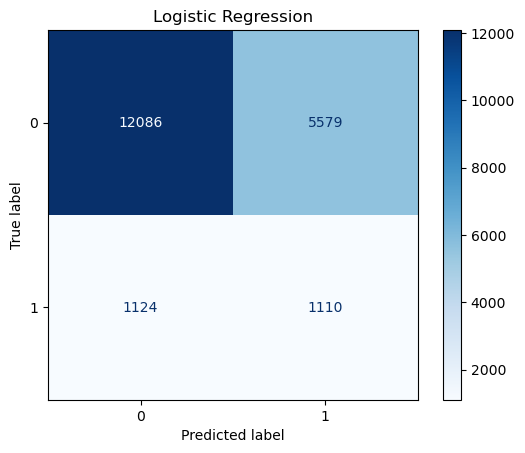


Random Forest Confusion Matrix:


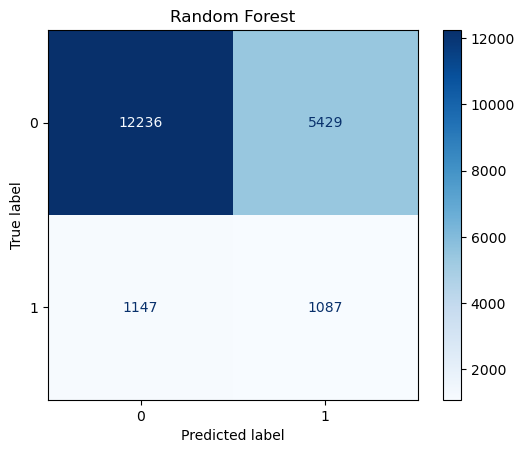


XGBoosting Confusion Matrix:


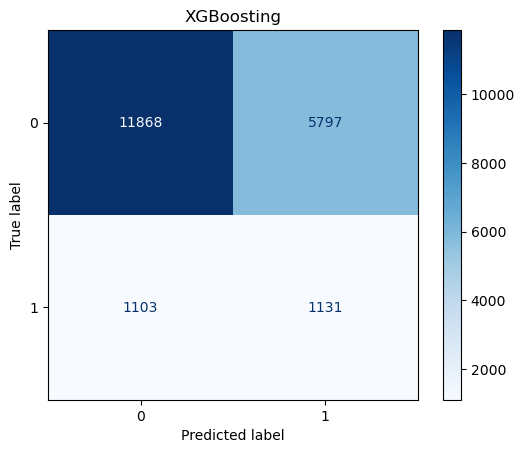

In [9]:
#========================================================
# CONFUSION MATRICES FOR ALL MODELS
#========================================================

models = {
    "Logistic Regression": log_reg_preds,
    "Random Forest": rf_preds,
    "XGBoosting": xg_preds
}

for name, preds in models.items():
    print(f"\n{name} Confusion Matrix:")
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name}")
    plt.show()

Logistic Regression AUC: 0.6309
Random Forest AUC:      0.6321
Gradient Boosting AUC:  0.6333


<Figure size 800x600 with 0 Axes>

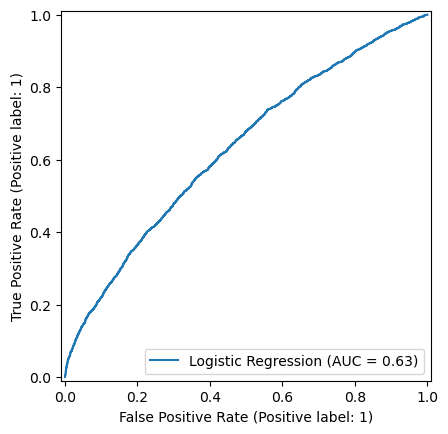

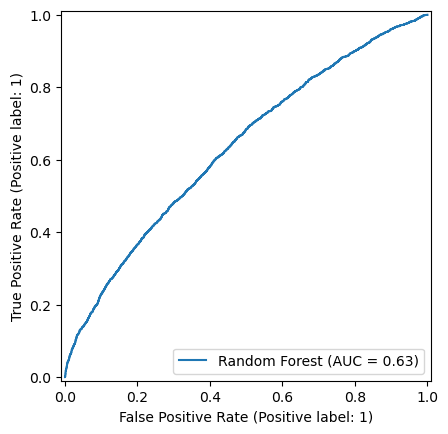

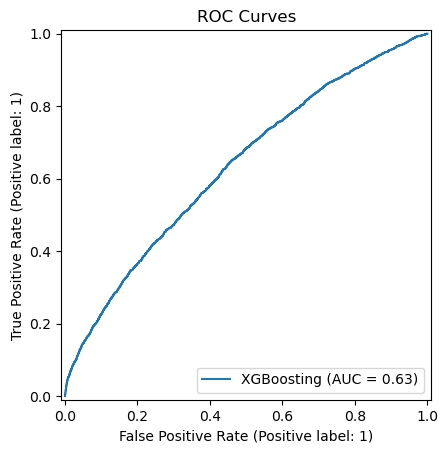

In [10]:
#========================================================
# ROC-AUC for all models + ROC Curve
#========================================================

# Compute AUC
auc_log = roc_auc_score(y_test, log_reg_probs)
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xg = roc_auc_score(y_test, xg_probs)

print(f"Logistic Regression AUC: {auc_log:.4f}")
print(f"Random Forest AUC:      {auc_rf:.4f}")
print(f"Gradient Boosting AUC:  {auc_xg:.4f}")

# Plot ROC curves
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, log_reg_probs, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, rf_probs, name="Random Forest")
RocCurveDisplay.from_predictions(y_test, xg_probs, name="XGBoosting")
plt.title("ROC Curves")
plt.show()

<Figure size 800x600 with 0 Axes>

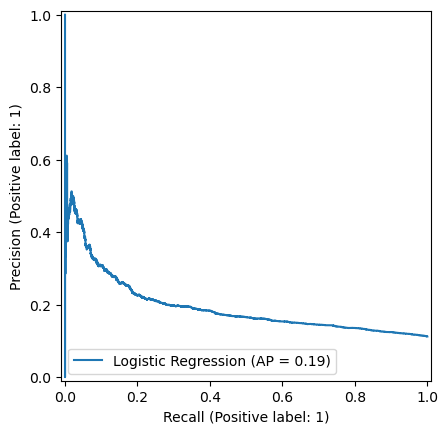

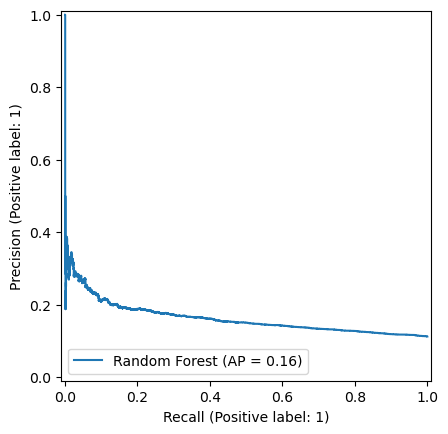

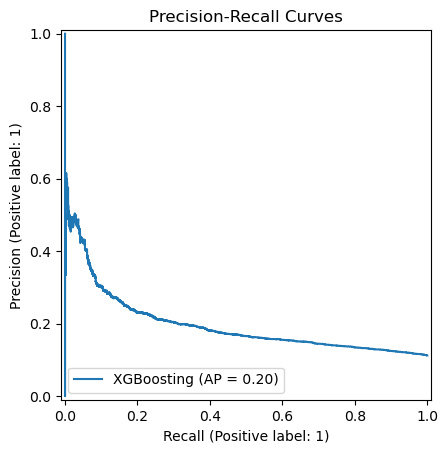

In [158]:
#========================================================
# PRECISION-RECALL CURVES
#========================================================

plt.figure(figsize=(8,6))

PrecisionRecallDisplay.from_predictions(y_test, log_reg_probs, name="Logistic Regression")
PrecisionRecallDisplay.from_predictions(y_test, rf_probs, name="Random Forest")
PrecisionRecallDisplay.from_predictions(y_test, xg_probs, name="XGBoosting")

plt.title("Precision-Recall Curves")
plt.show()


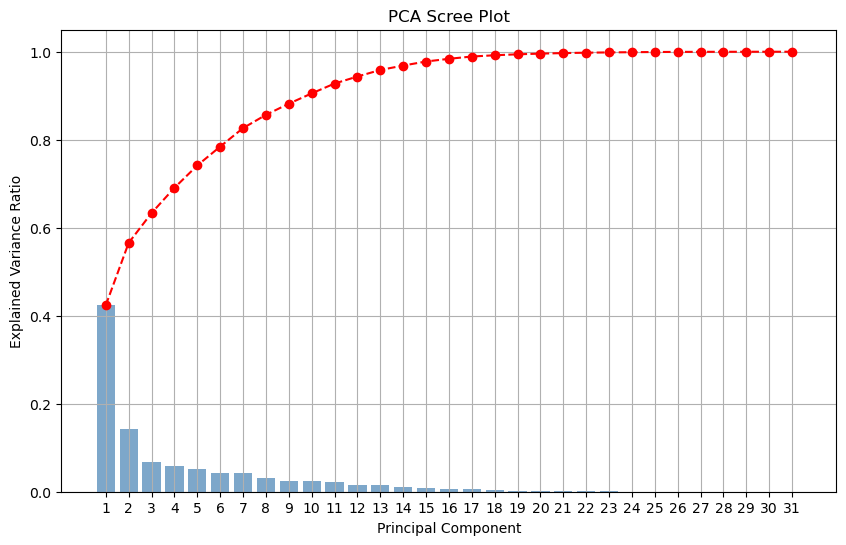

PC1: 0.4238 (0.4238 cumulative)
PC2: 0.1418 (0.5655 cumulative)
PC3: 0.0678 (0.6333 cumulative)
PC4: 0.0574 (0.6906 cumulative)
PC5: 0.0508 (0.7414 cumulative)
PC6: 0.0429 (0.7844 cumulative)
PC7: 0.0420 (0.8264 cumulative)
PC8: 0.0301 (0.8565 cumulative)
PC9: 0.0253 (0.8818 cumulative)
PC10: 0.0234 (0.9053 cumulative)
PC11: 0.0224 (0.9276 cumulative)
PC12: 0.0160 (0.9436 cumulative)
PC13: 0.0149 (0.9585 cumulative)
PC14: 0.0100 (0.9685 cumulative)
PC15: 0.0092 (0.9778 cumulative)


In [163]:
#========================================================
# PCA for feature importance / variance analysis
#========================================================

# Fit PCA on scaled continuous features only
pca = PCA()
pca.fit(X_train_scaled[continuous_cols])

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Scree plot: individual explained variance
plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='steelblue')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, color='red', marker='o', linestyle='--')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(True)
plt.show()

#print variance explained by first few components
for i, var in enumerate(explained_variance[:15], start=1):
    print(f"PC{i}: {var:.4f} ({cumulative_variance[i-1]:.4f} cumulative)")

In [166]:
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)
print(coef_df.head(10))

                feature  coefficient
50  admission_type_id_7    -1.578202
0                gender    -0.391781
8      number_inpatient     0.366385
14         pop_cvdstrk3    -0.355665
19         pop_havarth3    -0.338102
25          pop_medcost    -0.237821
43        race_Hispanic    -0.205858
31         pop_physhlth     0.185597
11          diabetesMed     0.183346
24         pop_hlthpln1    -0.177696
